# ISYE/Math/CS 425 - Assignment 4
### Members
- Bryan Luu
- Mehmet Ali Tever

All code in Julia version 1.5.2

## Contents
- [Helper functions](#Helper-functions)
- [Exercise 1](#Exercise-1)
- [Exercise 2](#Exercise-2)
- [Exercise 3](#Exercise-3)
- [Exercise 4](#Exercise-4)
- [Exercise 5](#Exercise-5)

## Helper functions

In [1]:
to_sym(v) = map(x->Symbol(x), v); # function to convert string into array of symbols

In [2]:
# calculate the flow into v given flows x
function flow(x, v)
    E = keys(x);
    inflow = sum(Float64[x[(i,j)] for (i,j) in E if j==v]);
    outflow = sum(Float64[x[(i,j)] for (i,j) in E if i==v]);
    inflow - outflow
end

flow (generic function with 1 method)

In [3]:
# Bread-first-search for (u,v)-path in the graph defined by adjacency list L
function BFS(L, u, v)
    V = keys(L);
    p = Dict{Any, Any}(zip(V, -1*ones(length(V))));
    p[u] = 0;
    q = [u]; # queue for BFS
    while !isempty(q)
        n = popfirst!(q);
        if n == v
            break
        end
        for (m, rev) in L[n]
            if p[m] == -1
                push!(q, m);
                p[m] = n;
            end
        end
    end
    i = v;
    path = [];
    while(i != u)
        if p[i] == -1
            return []
        end
        pushfirst!(path, i);
        i = p[i];
    end
    pushfirst!(path, u);
    path
end

BFS (generic function with 1 method)

In [14]:
# Augmenting path algorithm for graph G=(V,E), capacities u, and start r and end s.
function APA(G, u, r=:r, s=:s; verbose=false)
    V, E = G;
    
    # Initialize adjacency list L of augmented graph G' = G
    L = Dict{Any, Any}(zip(V, [[] for v in V]));
    for (u, v) in E
        push!(L[u], (v, false)); # the boolean represents whether the edge was reversed
    end
    
    # Construct flow vector
    x = Dict(zip(E, zeros(length(E))));
    
    path = BFS(L, r, s);
    i = 1;
    while(!isempty(path))
        if verbose
            println("---Iteration $(i)---")
        end
        # find x-width
        arcs = [p for p in zip(path[1:end-1], path[2:end])];
        eps1 = min(Inf, [u[(i,j)] - x[(i,j)] for (i,j) in arcs if (j, false) in L[i]]...);
        eps2 = min(Inf, [x[(j,i)] for (i,j) in arcs if (j, true) in L[i]]...);
        x_width = min(eps1, eps2);
        
        if verbose
            println(path)
            println("x-width: $(x_width)")
            println("e\tx[e]")
        end

        if x_width == Inf
            break
        end

        for e in arcs
            if e in E
                x[e] += x_width; # increase flow on forward arcs
            else
                x[reverse(e)] -= x_width; # decrease flow on reverse arcs
            end
        end

        if verbose
            for e in E
                println("$(e)\t$(x[e])")
            end
        end

        # construct augmented graph as adjacency list
        L = Dict{Symbol, Any}(zip(V, [[] for v in V])); # Adjacency list
        for (v, w) in E
            if x[(v, w)] < u[(v, w)]
                push!(L[v], (w, false)); # add a forward arc
            end
            if x[(v, w)] > 0
                push!(L[w], (v, true)); # add a reverse arc
            end
        end

        if verbose
            println("G':\n$(join(["$v\t$([u for (u, rev) in L[v]])" for v in V], "\n"))")
        end

        path = BFS(L, r, s);
        i += 1;
    end
    
    max_flow = flow(x, s);
                                    
    if verbose
        println("===== OPTIMUM FOUND =====")
        println("Max-flow: $(max_flow)")
    end
                                    
    return (max_flow, x);
end

APA (generic function with 3 methods)

## Exercise 1

### Part A
Construct a graph $G = (V, E)$, where $V$ and $E$ are defined below.

Let $N = \{j_1, j_2, \dots, j_n\}$ be the set of $n$ nationalities, and $T = \{i_1, i_2, \dots, i_t\}$ is the set of $t$ classrooms. Then the node set $V$ is defined as:

$V := \{r, s\} \cup N \cup T$, where $r$ and $s$ are extra source and sink nodes respectively.

The arcs of the graph are then:

$E := \{rj \forall j \in N\} \cup \{ji \forall j \in N, i \in T\} \cup \{is \forall i \in T\}$

The capacities of the arcs $u_e \forall e \in E$ are defined as:

$u_{rj} = \infty\ \forall j \in N$

$u_{ji} = 3\ \forall j \in N, i \in T$

$u_{is} = u_i\ \forall i \in T$

An example layout for $n = 4, t = 3$ is shown below.

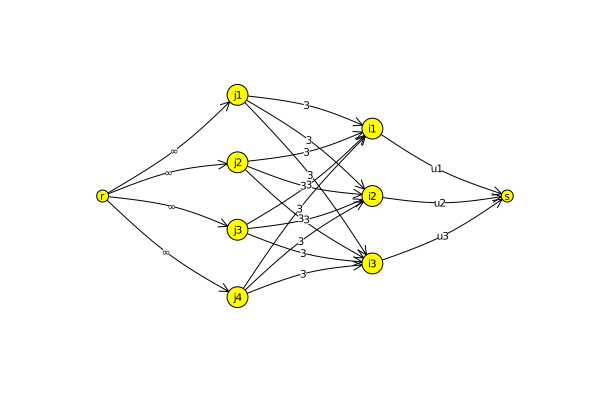

In [5]:
using GraphRecipes, Plots, LightGraphs

n, t = 4, 3;
N = ["j$(j)" for j in 1:n]; # Nationalities
T = ["i$(i)" for i in 1:t]; # Classrooms

V = Set(["r", N..., T..., "s"]); # Node set
Vd = Dict([(v, i) for (i, v) in enumerate(V)]); # Dict of node to index

g = SimpleDiGraph(length(Vd)); # create empty graph of nodes

edge_labels = Dict();
for j in N
    add_edge!(g, Vd["r"], Vd[j]);
    edge_labels[(Vd["r"], Vd[j])] = "∞";
    for i in T
        add_edge!(g, Vd[j], Vd[i]);
        edge_labels[(Vd[j], Vd[i])] = "3";
    end
end
for i in T
    add_edge!(g, Vd[i], Vd["s"]);
    edge_labels[(Vd[i], Vd["s"])] = "u$(i[end])";
end

pos = Dict();
pos["r"] = (0, 0);
for (j, v) in enumerate(N)
    pos[v] = (1, 0.5*((j-1) - (n-1)/2));
end
for (i, v) in enumerate(T)
    pos[v] = (2, 0.5*((i-1) - (t-1)/2));
end
pos["s"] = (3, 0);

x = [pos[v][1] for v in V];
y = [-pos[v][2] for v in V];

graphplot(g, names=[V...], edgelabel=edge_labels, x=x, y=y, 
    markersize=0.25, markercolor=colorant"yellow", nodeshape=:circle)

### Part B
Let $x$ be an integral feasible $(r,s)$-flow on $G$ with value $k$. 

Then $\sum\limits_{i \in T}x_{is} = k$. 

We can relate the flow $x_{ji}$ to the number of students enrolled in class $i$ with nationality $j$, because the capacities of student to a class from nationality $j$ is 3 and the capacities of classrooms is $u_i$. 

The total number of enrollments is therefore $\sum\limits_{j \in N, i \in T}x_{ji}$. 

Using the feasibility condition, $x_{is} = \sum\limits_j x_{ji}$, then the number of total enrollments is $\sum\limits_{j \in N, i \in T}x_{ji} = \sum\limits_{i \in T}\sum\limits_{j \in N}x_{ji} = \sum\limits_{i \in T}x_{is} = k$.

---

Now, let $P_1$ be the problem of finding the max enrollments, and $P_2$ be the max-flow problem. $I_1, I_2$ are the respective instances (where $I_1$ is the collection of nationalities, classrooms, and capacities, and $I_2$ is the graph defined above). Let $S_2$ be the max-flow solution to $I_2$. Because the objective function of the two problems is the same (i.e. $c = \sum\limits_{j \in N, i \in T}x_{ji}$), we need to show that $c(S_1) \geq c(S_2)$. The max-flow has value $c(S_2) = k* = \sum\limits_{i \in T}x_{is} = \sum\limits_{j \in N, i \in T}x_{ji} = c(S_1)$, so by definition this is equal. For the other direction, given optimal solution $\bar{S}_1$, the cost is $c(S_1) = \sum\limits_{j \in N, i \in T}x_{ji} = k*$ by using feasability condition again. So $P_1$ is reducible to $P_2$ if $I_2$ is the graph constructed above.

## Exercise 2

Max-flow instance set-up for Exercise 2

In [12]:
V_str = "rpbacsqd"; # String representing all nodes
V = Set(to_sym(collect(V_str)));

L = Dict{Symbol, Any}(zip(V, [[] for v in V])); # Adjacency list
L[:r] = [:p, :a, :q];
L[:p] = [:q, :b];
L[:b] = [:a, :s];
L[:a] = [:c, :d];
L[:c] = [:q, :s, :b];
L[:q] = [:p, :b, :d];
L[:d] = [:c, :s];

E = Set(); # Edge Set
for i in V
    for j in L[i]
        push!(E, (i, j));
    end
end

G = (V, E); # graph

Lu = Dict{Symbol, Any}(zip(V, [[] for v in V])); # Capacities in Adjacency List form
Lu[:r] = [6, 9, 4];
Lu[:p] = [2, 3];
Lu[:b] = [1, 8];
Lu[:a] = [8, 1];
Lu[:c] = [1, 4, 2];
Lu[:q] = [1, 2, 6];
Lu[:d] = [1, 6];

u = Dict{Any, Float64}(); # Capacities
for v in V
    for (i, w) in enumerate(L[v])
        u[(v, w)] = Lu[v][i]
    end
end

Call the `APA` function to solve for max-flow on G and u

In [15]:
max_flow, x = APA(G, u, verbose=true);

---Iteration 1---
Any[:r, :p, :b, :s]
x-width: 3.0
e	x[e]
(:q, :p)	0.0
(:p, :b)	3.0
(:r, :p)	3.0
(:a, :c)	0.0
(:b, :a)	0.0
(:a, :d)	0.0
(:c, :b)	0.0
(:b, :s)	3.0
(:p, :q)	0.0
(:d, :c)	0.0
(:c, :q)	0.0
(:c, :s)	0.0
(:r, :a)	0.0
(:r, :q)	0.0
(:d, :s)	0.0
(:q, :b)	0.0
(:q, :d)	0.0
G':
a	[:c, :d]
b	[:p, :a, :s]
p	[:r, :q]
d	[:c, :s]
s	[:b]
c	[:b, :q, :s]
r	[:p, :a, :q]
q	[:p, :b, :d]
---Iteration 2---
Any[:r, :a, :c, :s]
x-width: 4.0
e	x[e]
(:q, :p)	0.0
(:p, :b)	3.0
(:r, :p)	3.0
(:a, :c)	4.0
(:b, :a)	0.0
(:a, :d)	0.0
(:c, :b)	0.0
(:b, :s)	3.0
(:p, :q)	0.0
(:d, :c)	0.0
(:c, :q)	0.0
(:c, :s)	4.0
(:r, :a)	4.0
(:r, :q)	0.0
(:d, :s)	0.0
(:q, :b)	0.0
(:q, :d)	0.0
G':
a	[:c, :d, :r]
b	[:p, :a, :s]
p	[:r, :q]
d	[:c, :s]
s	[:b, :c]
c	[:a, :b, :q]
r	[:p, :a, :q]
q	[:p, :b, :d]
---Iteration 3---
Any[:r, :a, :d, :s]
x-width: 1.0
e	x[e]
(:q, :p)	0.0
(:p, :b)	3.0
(:r, :p)	3.0
(:a, :c)	4.0
(:b, :a)	0.0
(:a, :d)	1.0
(:c, :b)	0.0
(:b, :s)	3.0
(:p, :q)	0.0
(:d, :c)	0.0
(:c, :q)	0.0
(:c, :s)	4.0
(:r, :a)	5.0

Therefore the maximum-flow is 17, which is also the minimum-cut.

## Exercise 3

Let $P$ define an $(r, s)$-dipath with $u_e = \infty\ \forall e \in E$. Then, for any finite flow $x: x_e \geq 0\ \forall e \in P$ along this path, because $x$ is finite, $x_e \lt u_e$, and it connects $r$ to $s$, it is always an $x$-augmenting path. By Theorem 3.6, i.e. "a feasible flow $x$ is max if and only if there is no $x$-augmenting path", then the contrapositive is true: $x$ is not a max-flow if and only if there exists an $x$-augmenting path. Because $P$ is always an $x$-augmenting path, then $x$ is never a max-flow; no max-flow exists.

## Exercise 4

Choose $R = {r, q, a}$ to be the node-set that defines the cut, $\delta(R) = {rp, ap, as, qb}$. The flows on this cut all equal the capacities, i.e. $x_e = u_e\ \forall e \in \delta(R)$. Similarly, the complement-cut, $\bar{R} = {p, b, s}$ and $\delta(\bar{R}) = {pa, bq}$, contains no flow ($x_e = 0\ \forall e \in \delta(\bar{R})$). Therefore, using Corollary 3.8 means that $x$ as defined is a maximum-flow, and $\delta(R)$ is the corresponding minimum-cut.

To prove uniqueness of the minimum-cut:
- If we create a set $B$ with nodes reachable to $s$ from the node (call it $v$) via an augmenting path (i.e. a $(v, s)$-dipath in the auxiliary graph G'), then $\delta(\bar{B})$ is also a valid minimum-cut. Therefore if $\bar{B} = R$, the minimum-cut is unique.
- In the example flow from the diagram, $B = {p, b, s}$, and $\bar{B} = {r, q, a} = R$, therefore the minimum-cut is unique.

## Exercise 5

Max-flow instance set-up for Exercise 5, letting _P = {a,b,c,d,e,f,g,h,i,j}_ and _Q = {A,B,C,D,E,F,G,H,I,J}_.

In [8]:
P_str = "abcdefghij"; # Specify P here as a string
Q_str = uppercase(P_str); # Specify Q here as a string

P, Q = to_sym(collect(P_str)), to_sym(collect(Q_str)); # creates arrays for P and Q

V = Set([P..., Q..., :r, :s]); # Node Set

L = Dict{Symbol, Any}(zip(V, [[] for v in V])); # Adjacency list
L[:a] = [:A, :C, :D];
L[:b] = [:A, :B, :H];
L[:c] = [:A, :C];
L[:d] = [:C, :D];
L[:e] = [:C, :D];
L[:f] = [:B, :E, :G];
L[:g] = [:E, :F, :J];
L[:h] = [:E, :F, :G, :H, :J];
L[:i] = [:I];
L[:j] = [:D, :I];

L[:r] = P;
for v in Q
    L[v] = [:s];
end

E = Set(); # Edge Set
for i in keys(L)
    for j in L[i]
        push!(E, (i, j));
    end
end

G = (V, E); # graph

u = Dict(zip(E, Inf*ones(length(E)))); # Capacities
for p in P
    u[(:r, p)] = 1;
end
for q in Q
    u[(q, :s)] = 1;
end

Run APA (augmenting path algorithm) to find max matching

In [9]:
# x is now the max-flow
max_flow, x = APA(G, u, verbose=true);
# get matchings from flows
M = [(p, q) for (p, q) in keys(x) if x[(p, q)] == 1 && (in(p, P) || in(q, Q))];
println("Matchings:")
println(join(sort(M), "\n"))

---Iteration 1---
Any[:r, :b, :B, :s]
x-width: 1.0
e	x[e]
(:r, :b)	1.0
(:r, :d)	0.0
(:b, :B)	1.0
(:e, :C)	0.0
(:c, :C)	0.0
(:h, :H)	0.0
(:r, :i)	0.0
(:g, :F)	0.0
(:h, :F)	0.0
(:a, :D)	0.0
(:g, :J)	0.0
(:h, :E)	0.0
(:h, :J)	0.0
(:g, :E)	0.0
(:h, :G)	0.0
(:b, :A)	0.0
(:r, :j)	0.0
(:d, :C)	0.0
(:r, :a)	0.0
(:G, :s)	0.0
(:A, :s)	0.0
(:B, :s)	1.0
(:C, :s)	0.0
(:e, :D)	0.0
(:H, :s)	0.0
(:f, :E)	0.0
(:f, :G)	0.0
(:F, :s)	0.0
(:D, :s)	0.0
(:E, :s)	0.0
(:c, :A)	0.0
(:f, :B)	0.0
(:J, :s)	0.0
(:a, :C)	0.0
(:r, :h)	0.0
(:i, :I)	0.0
(:b, :H)	0.0
(:r, :g)	0.0
(:j, :I)	0.0
(:a, :A)	0.0
(:r, :c)	0.0
(:r, :e)	0.0
(:j, :D)	0.0
(:r, :f)	0.0
(:d, :D)	0.0
(:I, :s)	0.0
G':
j	(:I, false)
D	(:s, false)
d	(:C, false)
A	(:s, false)
g	(:F, false)
r	(:d, false)
a	(:D, false)
J	(:s, false)
i	(:I, false)
b	(:r, true)
F	(:s, false)
e	(:C, false)
B	(:b, true)
c	(:C, false)
h	(:H, false)
E	(:s, false)
s	(:B, true)
f	(:E, false)
I	(:s, false)
H	(:s, false)
G	(:s, false)
C	(:s, false)
---Iteration 2---
Any[:r, :d, :C, :

So the maximum-matching is above, with a cardinality of $|M| = 8$, which is also the minimum-cover.